#### Обучить генератор создавать точки, которые будут лежать на графике функции  𝑦=𝑠𝑖𝑛(𝑥)𝑥−𝑥10 . При выполненинии данного задания структура GAN остается той же, но Вам нужно:
* Сгенерировать настоящие данные
* Изменить архитектуру дискриминатора и генератора
* Без графиков домашку не принимаю

In [58]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

import matplotlib.patches as mpatches

In [59]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [171]:
n_epochs = 500
batch_size = 30
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

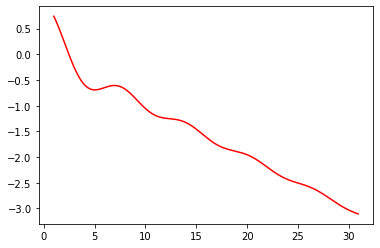

In [172]:
x = np.arange(1, 31, 0.1)
def func_y(x):
    return np.sin(x)/x - x/10
y = func_y(x) 

plt.plot(x, y, color = 'red')
plt.show()  

In [178]:
tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=batch_size,  shuffle=True,) 

In [187]:
class Generator(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1,int(input_length)),
            nn.Linear(int(input_length),int(input_length)),
            nn.Linear(int(input_length),int(input_length)),
            nn.Linear(int(input_length),1)
        )

    def forward(self, points):
        return self.model(points)


In [188]:
class Discriminator(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1,int(input_length)),
            nn.Linear(int(input_length),int(input_length)),
            nn.Linear(int(input_length),int(input_length)),
            nn.Linear(int(input_length),1),
        )
  

    def forward(self, points):
        return self.model(points)

In [189]:
generator = Generator(batch_size).to(device)
discriminator = Discriminator(batch_size).to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.MSELoss()

[Epoch 0/500] [Batch 9/30] [D loss: 2.900766] [G loss: 2.796597]


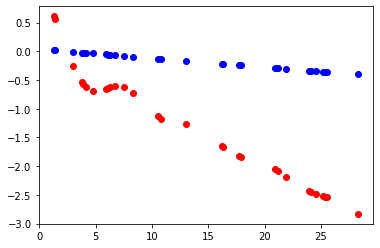

[Epoch 100/500] [Batch 9/30] [D loss: 0.221164] [G loss: 0.975166]


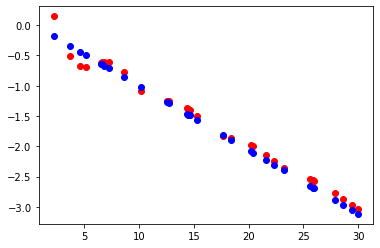

[Epoch 200/500] [Batch 9/30] [D loss: 0.477098] [G loss: 1.100258]


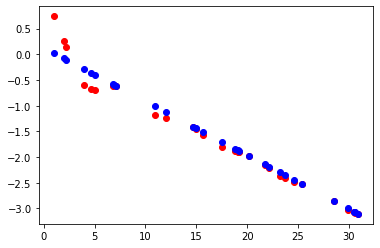

[Epoch 300/500] [Batch 9/30] [D loss: 0.386915] [G loss: 1.136380]


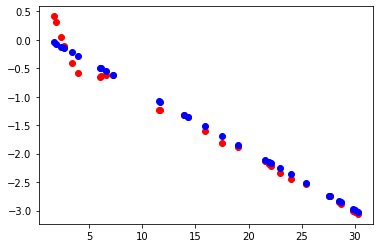

[Epoch 400/500] [Batch 9/30] [D loss: 0.366662] [G loss: 0.774280]


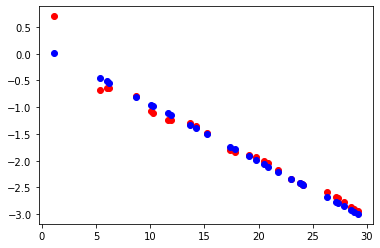

In [190]:
d_loss_history = []
g_loss_history = []


for epoch in range(n_epochs):
    for i, (x_, y_) in enumerate(my_dataloader):
######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()

        real_y = Variable(torch.FloatTensor(y_.reshape(y_.shape[0], -1))) #real y
        real_x = Variable(torch.FloatTensor(x_.reshape(x_.shape[0], -1))) #real x

        #генерация шума
        noise_x = torch.FloatTensor(batch_size,1).uniform_(1, 30) #noise x
        noise_y = Variable(torch.FloatTensor(func_y(noise_x).reshape(noise_x.shape[0], -1)))
        generated_y = generator(noise_x) #generated y

        pred_y = discriminator(generated_y) #gen y
        g_loss = adversarial_loss(pred_y, real_y)

        g_loss.backward()
        optimizer_G.step()

########################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_x)
        d_real_loss = adversarial_loss(real_pred, real_y)

        fake_pred = discriminator(generated_y.detach())
        d_fake_loss = adversarial_loss(fake_pred, noise_y)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
# ######## Отображение процесса обучения и вывод функций потерь ############
    
    if epoch % 100 == 0:
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, batch_size, d_loss.item(), g_loss.item()) ) 

        plt.plot(x_, y_, 'o', color = 'red')
        plt.plot(x_, real_pred.detach().numpy(), 'o', color = 'blue')
        plt.show()            
                     

#### Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [162]:
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [163]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [164]:
n_epochs = 2
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [165]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.model = nn.Sequential(
            nn.Linear(100, 256*7*7),
            View((-1, 256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Tanh()
        )


    def forward(self, z):
        return self.model(z)


In [166]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.ZeroPad2d((0, 1, 0, 1)),      # Паддинг до четного числа высоты и ширины изображения
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 0),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
  
    def forward(self, img):
        return self.model(img)

In [167]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

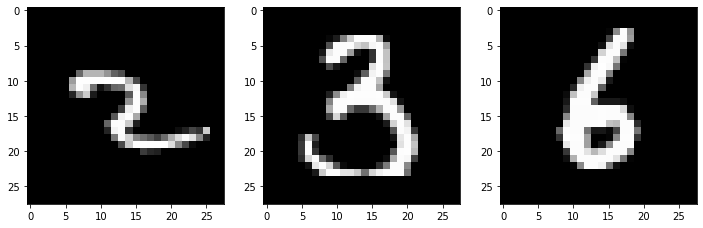

In [168]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [169]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [170]:
d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
#             plt.clf()
            
#             display.clear_output(wait=False)
#             sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
#             display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()


[Epoch 0/2] [Batch 0/938] [D loss: 0.686675] [G loss: 0.668353]
[Epoch 0/2] [Batch 25/938] [D loss: 0.093078] [G loss: 2.322343]
[Epoch 0/2] [Batch 50/938] [D loss: 0.008854] [G loss: 5.180448]
[Epoch 0/2] [Batch 75/938] [D loss: 0.014182] [G loss: 4.113544]
[Epoch 0/2] [Batch 100/938] [D loss: 0.024429] [G loss: 5.892085]
[Epoch 0/2] [Batch 125/938] [D loss: 0.001916] [G loss: 6.948019]
[Epoch 0/2] [Batch 150/938] [D loss: 0.004554] [G loss: 6.550998]
[Epoch 0/2] [Batch 175/938] [D loss: 0.002532] [G loss: 7.788094]
[Epoch 0/2] [Batch 200/938] [D loss: 0.002422] [G loss: 6.011823]
[Epoch 0/2] [Batch 225/938] [D loss: 0.002945] [G loss: 6.067529]
[Epoch 0/2] [Batch 250/938] [D loss: 0.000722] [G loss: 9.754185]
[Epoch 0/2] [Batch 275/938] [D loss: 0.000384] [G loss: 8.648279]
[Epoch 0/2] [Batch 300/938] [D loss: 0.004186] [G loss: 8.507963]
[Epoch 0/2] [Batch 325/938] [D loss: 0.005812] [G loss: 6.335189]
[Epoch 0/2] [Batch 350/938] [D loss: 0.271984] [G loss: 2.572681]
[Epoch 0/2] [Ba